In [1]:
import random as rnd
import numpy as np
import scipy
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
import copy
from scipy.spatial.distance import euclidean 
import pandas as pd 
import numpy as np
import math

from numpy.random import uniform
from scipy.stats import kstest, t, norm
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab
from wordcloud import WordCloud, STOPWORDS

# Задание 3.1

In [2]:
# расстояние системы сенсоров до плоскости
h = 1
#Координаты источника магнитного поля
p1 = 1
p2 = 1
#координаты дипольного  момента
q1 = 1
q2 = 1

#вектор степеней свободы
x = [p1, p2, q1, q2]


q0 = [q1, q2, 0]
p0 = [p1, p2, 0]

q = [q1, q2, 0]
p = [p1, p2, 0]

#Магнитная постоянная
mu0 = 1 

In [3]:
#Плоскость движения
r  = np.array([
  [2,2,h],
  [-2,-2,h],
  [2,-2,h],
  [-2,2,h]
])

n = len(r)


In [4]:
#Формула компоненты вектора магнитной индукции
def b_func (x,j):
#    print(x);
    p = [x[0], x[1], 0]
    q = [x[2], x[3], 0]
    v = r[j]-p
    len = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
    coord_z = q[0]*v[1] - v[0]*q[1]
    res = mu0/(4*np.pi)*(coord_z)/len**3
    return res

In [5]:
sigma = np.array([[1.0, 0.0, 0.0, 0.0],   
                  [0.0, 1.0, 0.0, 0.0],   
                  [0.0, 0.0, 1.0, 0.0],  
                  [0.0, 0.0, 0.0, 1.0]])
means = [0]*n
#Распределение шума
V  = np.random.multivariate_normal(means, sigma,1)

In [6]:
b = [0]*n
for i in range(0,n):
    b[i] = b_func([p1,p2,q1,q2],i)
y = b + V
y = y[0]

In [7]:
#Вектор средних
mean_vect = [p1, p2, q1, q2]
sd_matr = np.diag([1,1,1,1])

#Априорное распределение
def Prior_dist (x):
    q = ([0]*len(x))
    for i in range(0,len(q)):
        q[i] = (x[i] - mean_vect[i])
    q1 = [0]*len(x)
    for i in range(0,len(q1)):
        for j in range(0,len(q1)):
            q1[i]+=q[j]*sd_matr[i][j]
    sum =0 ;
    for i in range(0,len(q)):
        sum+=q[i]*q1[i]
    return(1/(2*np.pi)**2 * np.exp(-0.5*sum))#( q.dot(q1)[0])))

def Prior_dist1 (x):
    return scipy.stats.multivariate_normal.pdf(x, mean_vect, sd_matr)

#Функция правдоподобия

def Likelihood_func(x):
    sum = 1
#    print(len(x))
 #   print(y)
 #   print(len(sigma))
    for i in range(0,n):
        sum = sum *np.exp(-(y[i]-b_func(x,i))**2/(2*sigma[i,i]**2))
    return(sum)

def Posterior_func(x):
    return(Likelihood_func(x)*Prior_dist(x))


In [8]:
X = [0.47276088792328874, 0.17633185590312983, 0.3836756258610057, 0.8628060648381917];

print(mean_vect)
print(Prior_dist(X))
print(Prior_dist1(X))

[1, 1, 1, 1]
0.01286431301417603
0.012864313014176041


In [9]:

m = 10000

X = [0] * m
for i in range(m):
    X[i] = [0] * 4

X[0] = [-5, -5, q1, q2]
p_x = []
p_x.append(X[0][0])
p_y = []
p_y.append(X[0][1])
for k in range(1,m):
    Y =  np.random.multivariate_normal(X[k-1], np.diag([1,1,1,1]),1)
    alpha = min(1, Posterior_func(Y[0])/Posterior_func(X[k-1]))
    if(uniform() < alpha):
        X[k] = Y[0]
    else:
        X[k] = X[k-1]
    p_x.append(X[k][1])
    p_y.append(X[k][2])    


In [10]:
#Оценка максимума апостериорного распределения
maxx = -10000
for i in range(0,m):
    a = Posterior_func(X[i])
    if(a > maxx):
        maxx = a
        pos = X[i]
print(pos)
print(maxx)


[0.85453277 0.99285507 1.00256165 1.18545867]
0.0015495575700715121


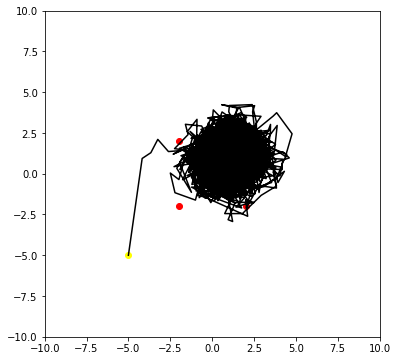

In [11]:
plt.figure(figsize=(6, 6))
plt.ylim([-10, 10])
plt.xlim([-10, 10])
plt.scatter([X[0][0]],[X[0][1]],c = "yellow")
plt.plot(p_x,p_y,c = "black")
plt.scatter(r[:,0], r[:, 1],c = "red")
plt.scatter( [p1], [p2], c = "pink")
plt.scatter([pos[1]],[pos[2]], c= "blue")

plt.show()

# Задание 3.2

In [12]:
#Количество тем
T = 3; 
#Параметры распределений дирихле
alpha = 0.1; 
beta = 0.1


In [13]:
#Считываем текст
data = []
with open("test1.dat") as f:
    for line in f:
        data.append([int(x)-1 for x in line.split()])

In [14]:
#Количество всех слов в словаре
W = data[0][1] 
#Количество  документов
D = data[0][0] 
for i in range(1,len(data)):
    W = max(W,data[i][1])
    D = max(D,data[i][0])
W+=1
D+=1
#print(D)
#print(W)
#общее количество слов, совпадающих с w,отнесенных к теме t, во всех документах
NWT = [0]*W
for i in range(0,W):
    NWT[i] =  [0]*T
#количество слов, отнесенных к теме t в текущем документе d;
NTD = [0]*T
for i in range(0,T):
    NTD[i] = [0]*D
#общее количество слов во всех документах, отнесенных к теме t.
NT = [0]*T
#Общее число слов в документе
N = [0]*D
#набор всех слов в корпусе
w = [0]*D
#разбиение всех слов по темам
z = [0]*D

In [15]:
for i in range(0,D):
    w[i] = [0]*0
#Подсчет количества слов в документе
for i in range(0,len(data)):
    w[data[i][0]] += ([data[i][1]]* data[i][2])
#Объявление 
for i in range(0,D):
    ll = len(w[i])
    N[i] = ll 
    z[i] = [0]* N[i]
#print(w)

In [16]:
#Инициализация/семплинг
for d in range(0,D):
    for n in range(0,N[d]):
        #Равновероятно генерируем тему от 0 до T-1
        u = math.floor(uniform(0,T,1))
        v = w[d][n]
        z[d][n] = u
        NWT[v][u] +=1;
        NTD[u][d] += 1
        NT[u] += 1

In [17]:
#print(NWT)
#print(NTD)

In [18]:
#Число итераций по схеме Гиббса
M = 10
for m in range(0,M):
    for d in range(0,D):
        for n in range(0,N[d]):
            u = z[d][n]
            v = w[d][n]
            NWT[v][u] -=1
            NTD[u][d] -=1
            NT[u] -=1
            p = [0]*T
            for t in range(0,T):
                p[t] = ((alpha + NTD[t][d])*(beta + NWT[v][t]))/(beta*W+NT[t])
            P = [0]*len(p)
            for i in range(0,len(P)):
                P[i] = p[i] / sum(p)
            #Моделирование ДСВ
            z[d][n] = stats.rv_discrete(values=([j for j in range(0,T)],P)).rvs() 
            u = z[d][n]
         #   print(z[d][n])
         #   print(w[d][n])
            NWT[v][u] += 1
            NTD[u][d] +=1
            NT[u]+=1

In [19]:
#print(NTD)
#print(NWT)
#print(z)

In [20]:
phi = [0]*T 
for i in range(0,T):
    phi[i] = [0]*W

theta = [0]*D 
for i  in range(0,D):
    theta[i]= [0]*T

In [21]:
#Вычисление оценок
for d in range(0,D):
    for t in range(0,T):
        #print(theta)
        theta[d][t] = (alpha + NTD[t][d])/(alpha*T+N[d])
        #print(theta)
       # print(NTD[t][d])print(theta[d][t])
#print(theta[0])
for t in range(0,T):
    for w in range(0,W):
        phi[t][w] = (beta + NWT[w][t])/(beta*W+NT[t])

In [22]:
print(phi)
print(theta)

[[0.4955156950672646, 0.4955156950672646, 0.002242152466367713, 0.002242152466367713, 0.002242152466367713, 0.002242152466367713], [0.002242152466367713, 0.002242152466367713, 0.002242152466367713, 0.002242152466367713, 0.4955156950672646, 0.4955156950672646], [0.002242152466367713, 0.002242152466367713, 0.4955156950672646, 0.4955156950672646, 0.002242152466367713, 0.002242152466367713]]
[[0.49862258953168054, 0.002754820936639119, 0.49862258953168054], [0.002754820936639119, 0.49862258953168054, 0.49862258953168054], [0.49862258953168054, 0.49862258953168054, 0.002754820936639119], [0.9759036144578312, 0.012048192771084336, 0.012048192771084336], [0.012048192771084336, 0.012048192771084336, 0.9759036144578312], [0.012048192771084336, 0.9759036144578312, 0.012048192771084336]]


In [23]:
vocab = pd.read_csv('test2.vocab', sep=" ", header=None)
theme = 0
maxx = theta[0][0]
for i in range(1,len(theta[0])):
               if theta[0][i] > maxx:
                   maxx = theta[0][i]
                   theme = i
#print(maxx)
#print(theme)
tmp = [0]*len(phi[theme])
for i in range(0,len(phi[theme])):
               tmp[i] = phi[theme][i]
tmp.sort(reverse = True)
cnt = 3
num_words = [0]*cnt
words = [0]*cnt
#rint(words)
#rint(phi[theme])
#rint(tmp)
#rint(len(phi[theme]))
#rint(cnt)
for i in range(0,cnt):
    for j in range(0,len(phi[theme])):
                if(phi[theme][j] == tmp[i]):
                    num_words[i] = j
   #print(num_words)
    words[i] = vocab[0][num_words[i]]

In [24]:
print(words)
print(tmp[0:cnt])

['abandon', 'abandon', 'abc']
[0.4955156950672646, 0.4955156950672646, 0.002242152466367713]


In [25]:
weights = dict([(words[i], tmp[i]) for i in range(0,T)])
#print(weights)

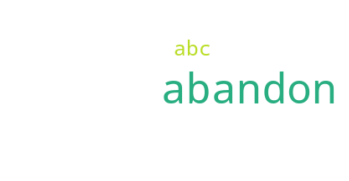

In [26]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(weights)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Задание 3.3

In [27]:
m = 500000
N = 100

beta1 = 5
beta2 = 5

x = [0]*N;
for i in range(0,N):
    x[i] = [0]*N

In [28]:
def U (sign, i, j):
    res = 0
    if(i > 0):
        res = res + (-beta1*x[i][j]*x[(i-1)][j])
    if(i < N - 1):
        res = res + (-beta1*x[i][j]*x[(i+1)][j])
    if(j > 0):
        res = res + (-beta2*x[i][j]*x[i][(j-1)])
    if(j < N - 1):
        res = res + (-beta2*x[i][j]*x[i][(j+1)])
    return(res* sign)

In [29]:
for i in range(0,N):
    for j in range(0,N):
        if(uniform() < 0.5):
            x[i][j] = -1
        else:
            x[i][j] = 1
x0  = [0]*len(x)
for i in range(0,len(x)):
    x0[i] = [0]*len(x)
for i in range(0,len(x)):
    for j in range(0,len(x)):
        x0[i][j] = x[i][j]
for k in range(0,m-1):
    pos = math.floor(uniform(0, N*N,1))
    i = math.floor(pos/N)
    j =  pos-i*N
    alpha = min(1, np.exp(-U(-1,i,j))/np.exp(-U(1,i,j)))
    if(uniform() < alpha):
        x[i][j] = -x[i][j]


In [30]:
M = [0]*(len(x))
for i in range(0,len(x)):
    M[i] = [0]*len(x)

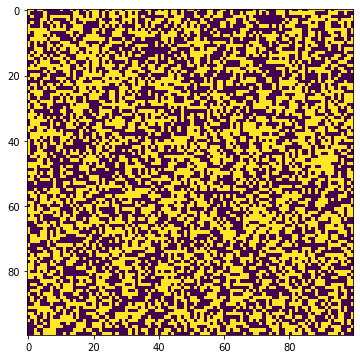

In [31]:
for i in range(0,N):
    for j in range(0,N):
        M[i][j] = x0[i][j]+1;
#print(M)
fig, ax = plt.subplots()

ax.imshow(M)

fig.set_figwidth(6)    
fig.set_figheight(6)    

plt.show()

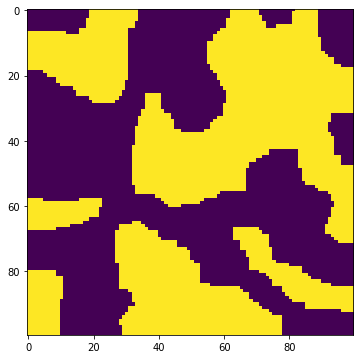

In [32]:
for i in range(0,N):
    for j in range(0,N):
        M[i][j] = x[i][j]+1;
#print(M)
fig, ax = plt.subplots()

ax.imshow(M)

fig.set_figwidth(6)    
fig.set_figheight(6)    

plt.show()